# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import io
import os
import numpy as np
import scipy
import scipy.linalg as linalg
from sklearn import linear_model, datasets
from sklearn.decomposition import PCA
from keras.layers import *
from keras import layers
import matplotlib.pyplot as plt
import sklearn.calibration as calibration
import pandas as pd
from sklearn import svm
import calendar
import re

In [44]:
#sets the path to the data folder
os.chdir('C://Users//Rebecca//Desktop//deep_learning//assignment2')

# 1) Monolingual (English) word embeddings 

In [45]:
#no need for embedding cause we already have the vectors
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())#create the corresponding vector from the numbers
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        self.word_list = np.array([])
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                #Please note that word_list was added as it was impossible to access the word  vector as a list
                #when running the w2v variable without getting an error (Compatibility Issue)
                self.word_list=np.append(self.word_list,word)

                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
    
        #first stores distances  each being compared word and the distance in arrays
        distances=np.array([])
        words=np.array([])
        
        for i in self.word2vec:
            returned_score = self.score(w,i)
            distances = np.append(distances,returned_score)
            words=np.append(words,i)

        #Finds the lowest distance with argpartition
        #then converts that into a word, using the array
        
        closest_K_words = words[distances.argsort()[-K:][::-1]] #closest words are the one with highest score: we order them and take the last 5 starting from the one with highest score
        return closest_K_words

    def score(self, w1, w2):
        v1=self.word2vec[w1]
        v2=self.word2vec[w2]       
        return np.dot(v1,v2.T)/(linalg.norm(v1)*linalg.norm(v2))

    def translate(self, w, K=5):
       # K most similar words: self.score  -  np.argsort
    
        #this will be used for the translation part: we start from the english word, consider the embedding, transform it with W,
        # and compare this result with the french words and find the one that is most similar
        distances=np.array([])
        words=np.array([])
        
        for i in self.word2vec:
            v2=self.word2vec[i]
            returned_score = np.dot(w,v2.T)/(linalg.norm(w)*linalg.norm(v2))
            distances = np.append(distances,returned_score)
            words=np.append(words,i)

        #Finds the lowest distance with argpartition
        #then converts that into a word, using the array
        
        closest_K_words = words[distances.argsort()[-K:][::-1]]
        return closest_K_words

In [4]:
w2v = Word2vec('crawl-300d-200k.vec', nmax=60000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 60000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cat' 'cats' 'kitty' 'kitten' 'feline']
['dog' 'dogs' 'puppy' 'Dog' 'doggie']
['dogs' 'dog' 'Dogs' 'doggies' 'canines']
['paris' 'france' 'Paris' 'london' 'berlin']
['germany' 'europe' 'german' 'berlin' 'france']


In [46]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentence, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
                
        sentemb=np.zeros([len(list(w2v.word_list))])            
        for word in sentence.split(' '):
            #in case the word from the sentence is not part of the word_list (computed earlier) we use the Try Except
            try:
                    #the below gets the sentemb by looping incrementally increasing the sentemb
                #zero vector whenever a word is found in the initial vocab under word_list
                sentemb[np.argwhere(w2v.word_list==word).item()]=sentemb[np.argwhere(w2v.word_list==word).item()] + 1
            except:
                None
            #move on to the next sentence

        i=0
        for sent in sentemb:
                #in case we are dowing the mean of word, we simply divide the word count by the 
                #total number of words in the sentence
                if idf==False:
                # mean of word vectors
                    sentemb[i] = sent / sentemb.sum()
                    i=i+1                        
                else:
                # idf-weighted mean of word vectors
                #assert False, 'TODO: fill in the blank' We removed the asset here as we did not 
                #see a use for it
                    sentemb[i] = sent * self.idf_dictionary.get(w2v.word_list[i],0)                
                    i=i+1
        
        return np.vstack(sentemb)
        

    def most_similar(self, s, sentences, idf=False, K=5):

        ############### This was changed so that the encoding happens in the scoring part of the code, in order
        #for the testing examples below don't get encoded twice (given that the score also is called directly)
        #by a sentence

        keys = sentences
        query = s
        scores=np.array([])
        
        for key in keys: 
            #loops on each individual sentence in sentences, encodes it (under score)
            #and appends the score to the scores array 
            scores = np.append(scores,self.score(key,query,idf))
        
        most_similar_sentences=np.array([])
        
        for k in scores.argsort()[-K:][::-1]:
            #add  the top k most similar sentences to most_similar sentences
            most_similar_sentences = np.append(most_similar_sentences,sentences[k])
        
        print(most_similar_sentences)
        
        return most_similar_sentences

    def score(self, s1, s2, idf=False):
        if s1 and s2:
        # cosine similarity: use   np.dot  and  np.linalg.norm
        #encodes the sentences and then does the cosine similarity
            v1=self.encode(s1,idf)
            v2=self.encode(s2,idf)
            output = np.dot(v1.T,v2)/(linalg.norm(v1)*linalg.norm(v2))
            return output
        else:
            return 0
        #return output
    
    
  

    
    
    
    
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        self.idf_dictionary = {}
        self.idf_flag = {}
        for sent in sentences:
            for word in sent.split(' '):
                if self.idf_flag.get(word,1)==True:
                    self.idf_dictionary[word] = self.idf_dictionary.get(word, 0) + 1
                    self.idf_flag[word] =False
            self.idf_flag={}
            
        for word in self.idf_dictionary.keys():
            self.idf_dictionary[word]= np.log10(len(sentences) / (self.idf_dictionary[word])) 
        return self.idf_dictionary

In [11]:
w2v = Word2vec('crawl-300d-200k.vec', nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open('sentences.txt') as myfile:
           sentences=myfile.read().split('\n')

#takes the first 5,000 sentences from the sentence file
sentences = sentences[:1000]

#removes punctuation and symbols from sentences
for x in range(int(len(sentences))):
    sentences[x] = re.sub('[0-9]','', sentences[x]).lower()
    sentences[x] = re.sub('\W+\s+\"','', sentences[x])
    sentences[x] = re.sub('#','', sentences[x])


# Build idf scores for each word
#we have changed the below to False, otherwise the IDF is never called and hence
#the idf dicitionnary is never built
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('5 most similar BoV-mean sentences to : "', sentences[10], '"')
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean

print('score BoV-mean between : "', '' if not sentences else sentences[7], '" and "', '' if not sentences else sentences[13], '"')
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = {}  
print('5 most similar idf sentences to : "', sentences[10], '"')
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print('score BoV-idf between : "', '' if not sentences else sentences[7], '" and "', '' if not sentences else sentences[13], '"')
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
5 most similar BoV-mean sentences to : "  smiling african american boy .  "
[' smiling african american boy . '
 'a  year old boy swings in the backyard . '
 'a caucasian woman reading a boy scout handbook . '
 ' girls and one boy playing in the street . '
 'a jewish boy behind the star of david . ']
score BoV-mean between : "  man singing and  man playing a saxophone in a concert .  " and "  people venture out to go crosscountry skiing .  "
[[0.03661035]]
5 most similar idf sentences to : "  smiling african american boy .  "
[' smiling african american boy . '
 'a caucasian woman reading a boy scout handbook . '
 ' girls and one boy playing in the street . '
 'a boy walking wearing a uniform . '
 'a jewish boy behind the star of david . ']
score BoV-idf between : "  man singing and  man playing a saxophone in a concert .  " and "  people venture out to go crosscountry skiing .  "
[[9.6980462e-05]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [12]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

en = Word2vec('wiki.en.vec', nmax=50000)
fr = Word2vec('wiki.fr.vec', nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [41]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common_words=np.array(list(set(en.word_list).intersection(set(fr.word_list))))

words_eng=list(en.word2vec.keys())
values_eng=list(en.word2vec.values())
words_values_eng=list([words_eng,values_eng])

french_words=list(fr.word2vec.keys())
french_values=list(fr.word2vec.values())
words_values_fr=list([french_words,french_values])

english_indices = [words_values_eng[0].index(x) for x in common_words]
X=np.array([words_values_eng[1][i] for i in english_indices])

french_indices = [words_values_fr[0].index(x) for x in common_words]
Y=np.array([words_values_fr[1][i] for i in french_indices])


In [14]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

def procrustes(X, Y):

    # optimum rotation matrix of Y

    A = np.dot(X.T, Y)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    return T

W_eng=procrustes(X, Y)
W_fr=procrustes(Y, X)

In [47]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
g=['music','love','mother']
for x in g: 
    gx=en.word2vec[x]
    g_new=np.dot(W_eng,gx)
    print('French translation of',x,fr.translate(g_new,5))

g=['liberté','égalité','fraternité']
for x in g:
    gx=fr.word2vec[x]
    g_new=np.dot(W_fr,gx)
    print('English translation of',x,en.translate(g_new,5))

French translation of music ['music' 'musique' 'musiques' 'musical' 'musicale']
French translation of love ['love' 'amour' 'lover' 'lovers' 'beautiful']
French translation of mother ['mère' 'sœur' 'tante' 'adoptive' 'fille']
English translation of liberté ['freedom' 'liberté' 'conscience' 'liberty' 'freedoms']
English translation of égalité ['equality' 'inequality' 'inequalities' 'equal' 'affirmative']
English translation of fraternité ['fraternity' 'brotherhood' 'fraternal' 'fraternities' 'sorority']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [47]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
os.chdir('C://Users//Rebecca//Desktop//deep_learning//assignment2//nlp_project//data//SST')

#loads data from data folder

# TYPE CODE HERE
with open('stsa.fine.train') as myfile_train:
           train_sentences=myfile_train.read().split('\n')

with open('stsa.fine.dev') as myfile_dev:
           dev_sentences=myfile_dev.read().split('\n')
        
with open('stsa.fine.test.X') as myfile_test:
           test_sentences=myfile_test.read().split('\n')

def cleaning_sentences(sentences):
    for x in range(int(len(sentences))):
        sentences[x] = re.sub('[0-9]','', sentences[x]).lower()
        sentences[x] = re.sub('\W+\s+\"','', sentences[x])
        sentences[x] = re.sub('#','', sentences[x])
    return sentences

def extracting_label_train(train_sentences):
    train_labels = list()
    train_f = list()
    for i in range(len(train_sentences)-1):
        train_labels.append(int(train_sentences[i][0]))
        train_f.append(train_sentences[i][1:])

    return train_labels,train_f

train_labels,train_f = extracting_label_train(train_sentences)
dev_labels,dev_f = extracting_label_train(dev_sentences)

train_f = cleaning_sentences(train_f)
dev_f = cleaning_sentences(dev_f)
test_sentences = cleaning_sentences(test_sentences)

In [48]:
# 2 - Encode sentences with the BoV model above
os.chdir('C://Users//Rebecca//Desktop//deep_learning//assignment2')


print('BoV TFIdf start')
w2v = Word2vec('crawl-300d-200k.vec', nmax=10000)
s2v_logistic = BoV(w2v)
idf = {} if False else s2v_logistic.build_idf(train_f)

print('producing sentences embeddings')
print('train test')
#Produces the sentemb using the idf methodology
train_enc_idf = np.zeros([len(train_f),len(w2v.word2id)])
for x in range(int(len(train_f))):
    train_enc_idf[x] = list(s2v_logistic.encode(train_f[x],s2v_logistic.idf_dictionary))

print('encoding dev test')
dev_enc_idf = np.zeros([len(dev_f),len(w2v.word2id)])
for x in range(int(len(dev_f))):
    dev_enc_idf[x] = list(s2v_logistic.encode(dev_f[x],s2v_logistic.idf_dictionary))

print('encoding test set')
test_enc_idf = np.zeros([len(test_sentences)-1,len(w2v.word2id)])
for x in range(int(len(test_sentences))-2):
    test_enc_idf[x] = list(s2v_logistic.encode(test_sentences[x],s2v_logistic.idf_dictionary))

    
print('BoV Average method')
    
#Produces the sentemb using the average word methodology
s2v_logistic_average_word = BoV(w2v)


print('encoding train test')
train_enc_average_word = np.zeros([len(train_f),len(w2v.word2id)])
for x in range(int(len(train_f))):
    train_enc_average_word[x] = list(s2v_logistic_average_word.encode(train_f[x]))
print('dev test')

dev_enc_average_word = np.zeros([len(dev_f),len(w2v.word2id)])
for x in range(int(len(dev_f))):
    dev_enc_average_word[x] = list(s2v_logistic_average_word.encode(dev_f[x]))
print('test set')

test_enc_average_word = np.zeros([len(test_sentences)-1,len(w2v.word2id)])
for x in range(int(len(test_sentences))-2):
    test_enc_average_word[x] = list(s2v_logistic_average_word.encode(test_sentences[x]))

BoV TFIdf start
Loaded 10000 pretrained word vectors
producing sentences embeddings
train test
encoding dev test
encoding test set
BoV Average method
encoding train test
dev test
test set


In [51]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

#different penalties regularization paramaters
C =[1,0.5,0.1,0.2,1,2,0.001]

print('IDF-Model')

model_array=[]
scores_cv_IDF=[]

#IDF Method:
#looping on the levels and choosing the one with the highest score

for x in C:
    model  = linear_model.LogisticRegression(solver = 'sag', penalty='l2',C=x, multi_class = 'multinomial')
    model_array.append(model.fit(train_enc_idf,train_labels))
    

for model_cv in model_array:
    scores_cv_IDF.append(model_cv.score(dev_enc_idf,dev_labels))


#getting the model with the highest score
best_model_idf = model_array[np.argmax(scores_cv_IDF)]
score_idf_model = best_model_idf.score(dev_enc_idf,dev_labels)


print('Average Model')

scores_cv_Avg=[]

#Average Word Method:
#looping on the levels and choosing the one with the highest score
model_array=[]        

for x in C:
    model  = linear_model.LogisticRegression(solver = 'sag', penalty='l2',C=x, multi_class = 'multinomial')
    model_array.append(model.fit(train_enc_average_word,train_labels))

for model_cv in model_array:
    scores_cv_Avg.append(model_cv.score(dev_enc_average_word,dev_labels))


#getting the model with the highest score
best_model_average_word = model_array[np.argmax(scores_cv_Avg)]
score_avg_model = best_model_average_word.score(dev_enc_average_word,dev_labels)

predict_y_avg = best_model_average_word.predict_proba(dev_enc_average_word)
predict_y_idf = best_model_idf.predict_proba(dev_enc_idf)

print("Score for Average Model in the training set is ", best_model_average_word.score(train_enc_average_word,train_labels),\
" and Score for idf model in training set is", best_model_idf.score(train_enc_idf,train_labels))

print("Score for Average Model in the dev set is ", score_avg_model, " and Score for idf model in the dev set is", score_idf_model)
print("Error for Average Model in the dev set is ", metrics.log_loss(dev_labels, predict_y_avg), " and Error for idf model in the dev set is"\
, metrics.log_loss(dev_labels, predict_y_idf))

print(best_model_idf)#C best=0.1
print(best_model_average_word)#Cbest=1

#average model is better in the dev set

IDF-Model


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Average Model
Score for Average Model in the training set is  0.5602762172284644  and Score for idf model in training set is 0.8073501872659176
Score for Average Model in the dev set is  0.38782924613987285  and Score for idf model in the dev set is 0.3723887375113533
Error for Average Model in the dev set is  1.419806844191778  and Error for idf model in the dev set is 1.556918550001064
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)


In [52]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

#we use the average model cause it's better
output = best_model_average_word.predict(test_enc_average_word).astype(int)
dataframe_output = pd.DataFrame()
dataframe_output['Label'] = output
dataframe_output['Label'].to_csv('logreg_bov_y_test_sst.txt', index=False)

#####################################
#Please note that we have already captured the lables from the trees. But we have included the 
#test predicitons from the above model in the deliverables without doing any training on the test set
#####################################

In [84]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

#the point here is to use pca in order to deal with the sparsity of the data. having tried different methods (RF,perceptron, GB)
#we'll later find out that GB classifier is the best one
print('Performing PCA')
pca = PCA(n_components=350, svd_solver='full')
train_PCA = pca.fit_transform(train_enc_average_word)
CV_PCA = pca.fit_transform(dev_enc_average_word)
test_PCA = pca.fit_transform(test_enc_average_word)




model_array_svc=[]

C =[1,2,5,0.1,0.2,0.001]
from sklearn.ensemble import GradientBoostingClassifier
print('Performing SVC')
for x in C:
    lin_clf = svm.LinearSVC(penalty='l2', C=x)
    clf = calibration.CalibratedClassifierCV(lin_clf) #, method = 'Simgoid', cv='prefit')
    clf.fit(train_PCA, train_labels)
    model_array_svc.append(clf)

print('Building the Best Model')
scores_svc=[]
for model_cv_svc in model_array_svc:
    scores_svc.append(model_cv_svc.score(CV_PCA,dev_labels))

best_model_avw_svc = model_array_svc[np.argmax(scores_svc)]
pred_y_proba = clf.predict_proba(CV_PCA)

#predict the labels for test set
#GB is the best one so we produce the outputs with that model, not SVC


print("SVC plus  PCA")
print("Score for Average Model in training set is ", best_model_avw_svc.score(train_PCA,train_labels))
print("Score for Average Model in dev is ", best_model_avw_svc.score(CV_PCA,dev_labels))
print("Error for Average Model in dev is ", metrics.log_loss(dev_labels, pred_y_proba))

################################################


from sklearn.ensemble import GradientBoostingClassifier
print('Performing GB')
GB_classifier = GradientBoostingClassifier(n_estimators=40)
GB_classifier.fit(train_enc_average_word, train_labels)

print('Building the Best Model')
pred_y_proba = GB_classifier.predict(dev_enc_average_word)

print("Score for Average Model in TRAINING is ",GB_classifier.score(train_enc_average_word,train_labels))
print("Score for Average Model in DEV is ",GB_classifier.score(dev_enc_average_word,dev_labels))


# TYPE CODE HERE
output = GB_classifier.predict(test_enc_average_word).astype(int)
df_output = pd.DataFrame()
df_output['Label'] = output
df_output['Label'].to_csv('GB_bov_y_test_sst.txt', index=False)




Performing PCA
Performing SVC
Building the Best Model
SVC plus  PCA
Score for Average Model in training set is  0.363998127340824
Score for Average Model in dev is  0.25885558583106266
Error for Average Model in dev is  1.6127538909155068
Performing GB
Building the Best Model
Score for Average Model in TRAINING is  0.45517322097378277
Score for Average Model in DEV is  0.329700272479564


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [4]:
import keras

C:\Users\Rebecca\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# 1 - Load train/dev/test sets of SST
os.chdir('C://Users//Rebecca//Desktop//deep_learning//assignment2//nlp_project//data//SST')
# TYPE CODE HERE
with open('stsa.fine.train') as myfile_train:
           train_sentences=myfile_train.read().split('\n')

with open('stsa.fine.test.X') as myfile_train:
           test_sentences=myfile_train.read().split('\n')

with open('stsa.fine.dev') as myfile_train:
           dev_sentences=myfile_train.read().split('\n')

def extracting_label(train_sentences):
    train_sentence_y=list()
    train_sentence_x=list()
    
    for i in range(len(train_sentences)-1):
        train_sentence_y.append(int(train_sentences[i][0]))
        train_sentence_x.append(train_sentences[i][1:])

    return train_sentence_y,train_sentence_x

train_sentence_y,train_sentence_x=extracting_label(train_sentences)
dev_sentence_y,dev_sentence_x=extracting_label(dev_sentences)

In [8]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# We need the size of vocabulary to get maximum vocabulary 

train_sentence_x_hot_encoding=[]
dev_sentence_x_hot_encoding=[]
test_sentence_x_hot_encoding=[]

for i in range(len(train_sentence_x)-1):
    train_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(train_sentence_x[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))
for i in range(len(dev_sentence_x)-1):
    dev_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(dev_sentence_x[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))  
for i in range(len(test_sentences)-1):
    test_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(test_sentences[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))  

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# To get the maximum length of a sentence we will find it out and put that as the input as maxsqlen

max_train_sentence=[]
max_dev_sentence=[]
max_test_sentence=[]

for i in range(len(train_sentence_x_hot_encoding)-1):
    max_train_sentence.append(len(train_sentence_x_hot_encoding[i]))
max_train=max(max_train_sentence)

for i in range(len(dev_sentence_x_hot_encoding)-1):
    max_dev_sentence.append(len(dev_sentence_x_hot_encoding[i]))
max_dev=max(max_dev_sentence)

for i in range(len(test_sentence_x_hot_encoding)-1):
    max_test_sentence.append(len(test_sentence_x_hot_encoding[i]))
max_test=max(max_test_sentence)


print(max_train)
print(max_dev)
print(max_test)
max_length=max_test
X_train = keras.preprocessing.sequence.pad_sequences(train_sentence_x_hot_encoding, maxlen=max_length, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test = keras.preprocessing.sequence.pad_sequences(test_sentence_x_hot_encoding, maxlen=max_length, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_dev = keras.preprocessing.sequence.pad_sequences(dev_sentence_x_hot_encoding, maxlen=max_length, dtype='int32', padding='pre', truncating='pre', value=0.0)

from keras.utils import np_utils
train_sentence_y=np_utils.to_categorical(train_sentence_y)
dev_sentence_y=np_utils.to_categorical(dev_sentence_y)

49
44
52


## 4.2 - Design and train your model

In [10]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier


embed_dim  = 32  # word embedding dimension
nhid       = 20  # number of hidden units in the LSTM
vocab_size = 5000  # size of the vocabulary
n_classes  = 5

    # create model
model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.05, dropout_U=0.05))
model.add(Dense(n_classes, activation='sigmoid'))
#    return model

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, dropout=0.05, recurrent_dropout=0.05)`


In [37]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras.optimizers import SGD,Adam, RMSprop

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer_chosen       =  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # find the right optimizer
metrics_classif  =  ['accuracy']
#optimizer_chosen=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#optimzer_chosen=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)


#adam is better than sgd and rmsprop
# Observe how easy (but blackboxed) this is in Keras



#same as above
    
model.compile(loss=loss_classif,
                optimizer=optimizer_chosen,
                metrics=metrics_classif)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 32)          160000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                4240      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 105       
Total params: 164,345
Trainable params: 164,345
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, dropout=0.05, recurrent_dropout=0.05)`
  
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8543 samples, validate on 1100 samples
Epoch 1/2
8543/8543 [==============================] - 10s 1ms/step - loss: 1.5651 - acc: 0.2921 - val_loss: 1.5144 - val_acc: 0.3455
Epoch 2/2
8543/8543 [==============================] - 5s 636us/step - loss: 1.4015 - acc: 0.3804 - val_loss: 1.4390 - val_acc: 0.3627
Accuracy: 36.27%
0.3627272728356448


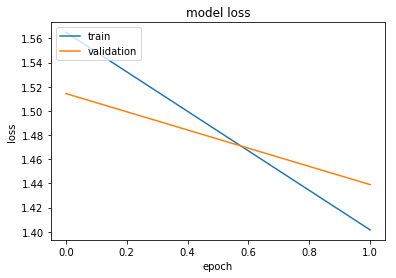

In [39]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set


# ADAPT CODE BELOW
#bs = 64
#n_epochs = 5
#from sklearn.model_selection import GridSearchCV


def new_model_create():
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim))
    model.add(LSTM(nhid, dropout_W=0.05, dropout_U=0.05))
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss=loss_classif,
                    optimizer=optimizer_chosen,
                    metrics=metrics_classif)
    return model



scores_temp=0
# ADAPT CODE BELOW
       
model=new_model_create()
history = model.fit(X_train, np.array(train_sentence_y[0:8543]), batch_size=64, nb_epoch=2, validation_data=(X_dev, np.array(dev_sentence_y[0:1100])))
scores = model.evaluate(X_dev, np.array(dev_sentence_y[0:1100]), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
if scores[1]>scores_temp:
    batch_size_final=64
    epoch_final=2
    scores_temp=scores[1]
    
print(scores_temp)


# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#different values for n of epochs and batch sizes have been tried
#We see here that model with 2 epochs and 64 batch size and adam opt, gives the besst accuracy of 36.3%
#rmsprop gives 32.55%
#sgd gives29.55%

In [40]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.


model=new_model_create()
history = model.fit(X_train, np.array(train_sentence_y[0:8543]), batch_size=batch_size_final, nb_epoch=epoch_final, validation_data=(X_dev, np.array(dev_sentence_y[0:1100])))
scores = model.evaluate(X_dev, np.array(dev_sentence_y[0:1100]), verbose=0)

# TYPE CODE HERE
result=model.predict_classes(X_test)
np.savetxt("logreg_lstm_y_test_sst.txt", result, delimiter=" ", newline = "\n", fmt="%s")

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, dropout=0.05, recurrent_dropout=0.05)`
  
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 8543 samples, validate on 1100 samples
Epoch 1/2
8543/8543 [==============================] - 10s 1ms/step - loss: 1.5464 - acc: 0.3121 - val_loss: 1.4540 - val_acc: 0.3627
Epoch 2/2
8543/8543 [==============================] - 6s 745us/step - loss: 1.3442 - acc: 0.4090 - val_loss: 1.4243 - val_acc: 0.3745


## 4.3 -- innovate !

In [18]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from keras.layers import *
from keras import layers

embedding_dim = 32

model_final = Sequential()
model_final.add(layers.Embedding(5000, embedding_dim, input_length=max_test))
model_final.add(layers.Conv1D(128, 5, activation='relu'))
model_final.add(Bidirectional(LSTM(128, return_sequences=True)))
model_final.add(layers.GlobalMaxPooling1D())
model_final.add(layers.Dense(10, activation='relu'))
model_final.add(layers.Dense(5, activation='sigmoid'))
model_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_final.summary()




batch_sz = 170
n_epochs = 2 # different values have been tried, but after 2 epochs, the val accuracy starts to decrease



history=model_final.fit(X_train, np.array(train_sentence_y[0:8543]), batch_size=batch_sz, nb_epoch=n_epochs, validation_data=(X_dev, np.array(dev_sentence_y[0:1100])))
loss, accuracy = model_final.evaluate(X_train, np.array(train_sentence_y[0:8543]), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_final.evaluate(X_dev, np.array(dev_sentence_y[0:1100]), verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))


result_new=model.predict_classes(X_test)
np.savetxt("Bidirectional_LSTM_y_test_sst.txt", result_new, delimiter=" ", newline = "\n", fmt="%s")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 52, 32)            160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 128)           20608     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 48, 256)           263168    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 55        
Total params: 446,401
Trainable params: 446,401
Non-trainable params: 0
_________________________________________________________________


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8543 samples, validate on 1100 samples
Epoch 1/2
8543/8543 [==============================] - 49s 6ms/step - loss: 0.5369 - acc: 0.7938 - val_loss: 0.5024 - val_acc: 0.8000
Epoch 2/2
8543/8543 [==============================] - 44s 5ms/step - loss: 0.5003 - acc: 0.8000 - val_loss: 0.4962 - val_acc: 0.8000
Training Accuracy: 0.8000
Validation Accuracy:  0.8000
